In [1]:
# import basic packages for managing dataframe
import pandas as pd
import numpy as np
from datetime import datetime

# import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# regardless warnings
import warnings 
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# import model package 
# regression and classification
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier

#clustering
from sklearn.cluster import KMeans

# import measurement package
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn import metrics


# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

 

### Read CSV

In [2]:
df_train_1 = pd.read_csv('train.csv',engine='python')
df_test_1 = pd.read_csv('test.csv',engine='python')

In [3]:
# how many rows in train dataset
len(df_train_1)

12043

In [4]:
# how many rows in test dataset
len(df_test_1)

5162

In [5]:
# Extract variables
columns_not_include = ['RECORDID','Tags','Tag_Count' 'Vec_Tags', 'Body', 'Body_Lemm',
       'Body_Lemm_lower', 'Body_Token','Body_Length','Title', 'Title_Lemm',
       'Title_Lemm_lower', 'Title_Token']

# split train and test
X_train = df_train_1.loc[:, ~df_train_1.columns.isin(columns_not_include)]

X_test = df_test_1.loc[:, ~df_test_1.columns.isin(columns_not_include)]


X_train= X_train.iloc[:,2:]
X_test= X_test.iloc[:,2:]


# 1. Check train and test dataset

In [11]:
# Check whether there are some tags that occur in train dataset but not in test dataset

def train_test_check(df_train, df_test):

    sum_train=[]
    sum_test=[]
    # Loop 156 tags
    for num_models in range(0,156): 
        # create y_train and y_test
        y_train = []
        y_test = []
        for i  in range(len(df_train)):
            y_train.append(int(df_train['Vec_Tags'].iloc[i].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
        for j  in range(len(df_test)):
            y_test.append(int(df_test['Vec_Tags'].iloc[j].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))

        sum_train.append(sum(y_train))
        sum_test.append(sum(y_test))

    # save result in train_test dataframe
    data_tuples = list(zip(sum_train,sum_test))
    train_test = pd.DataFrame(data_tuples,columns=['sum_train','sum_test'])
    print('There are ',len(train_test[train_test['sum_test']==0]), 'tags that never occur in test dataset')

    return train_test

In [12]:
train_test = train_test_check(df_train_1,df_test_1)

There are  0 tags that never occur in test dataset


In [13]:
train_test

,sum_train,sum_test
0,1712,721
1,721,319
2,36,14
3,8109,3484
4,467,198
...,...,...
151,20,5
152,24,5
153,21,7
154,24,16


# 2. Get new tag index list
### --since for new train and test dataset from new preprocessing pipeline, all tags occur in both train and test dataset, so we can ignore this part


Since there are 200 tags in orginal train and test dataset, but there are some tags never occurring in test dataset. So, I removed those tag and get the new tag index list in order to use it in the model part.  (remove those tags that never occur in test dataset in both train and test)

In [42]:
def tag_new(df):
    tag_index_original = list(range(0, 200))
    tag_index_new=[]
    for i in tag_index_original:
        if i in df[df['sum_test']==0].index:
            pass
        else:
            tag_index_new.append(i)
    return tag_index_new

In [43]:
tag_index_new = tag_new(train_test)

# 3. Shape Y and X

In [14]:
columns_not_include = ['RECORDID','Tags','Tag_Count' 'Vec_Tags', 'Body', 'Body_Lemm',
       'Body_Lemm_lower', 'Body_Token','Body_Length','Title', 'Title_Lemm',
       'Title_Lemm_lower', 'Title_Token']

# split train and test
X_train = df_train_1.loc[:, ~df_train_1.columns.isin(columns_not_include)]

X_test = df_test_1.loc[:, ~df_test_1.columns.isin(columns_not_include)]


X_train= X_train.iloc[:,2:]
X_test= X_test.iloc[:,2:]


In [15]:
# Run PCA for the total dataset(Train+Test)


X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(0.9)
pca.fit(X_train)
X_train = pd.DataFrame(pca.transform(X_train))
X_test = pd.DataFrame(pca.transform(X_test))



In [16]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,446,447,448,449,450,451,452,453,454,455
0,-2.110673,-2.330031,-1.985921,-2.151518,-2.580617,-2.897238,0.873784,0.956427,3.101483,-3.083324,...,-0.308150,0.604559,0.251856,-0.444476,0.352159,0.614821,0.374428,0.849755,0.372463,-0.303358
1,-2.600041,-3.697822,-3.496943,-4.610797,18.462762,2.410515,-4.849950,0.303531,0.135574,0.114154,...,-0.068508,-0.018367,-0.101448,-0.658715,0.135631,0.013936,-0.212882,-0.299534,0.432371,0.306236
2,-1.082777,-2.591346,-2.754188,-1.085038,-2.413186,-1.927308,-3.307778,-2.610376,-2.193293,1.527156,...,-0.608218,-1.242793,1.158685,0.225141,-0.086899,0.522922,0.632412,0.036456,-0.060067,0.850224
3,-1.401909,-1.688077,12.028146,13.262516,3.928952,-4.570885,-4.415856,2.886339,3.347392,-2.899913,...,1.333643,-0.112734,1.059170,1.558584,-0.214717,-0.995905,-0.361435,-0.095134,-2.202120,0.356322
4,-11.619928,63.410967,-23.021028,16.322925,2.513534,4.416908,1.285563,2.227122,1.031738,-0.804757,...,0.487173,1.349427,-0.054041,-0.277207,-0.297705,-0.617585,-0.460148,-0.141601,-0.850102,-0.092142


In [17]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,446,447,448,449,450,451,452,453,454,455
0,-8.309332,41.104302,-15.595759,7.579584,-0.069045,1.417708,-4.421424,-1.114664,-1.043570,6.148288,...,-0.544469,2.758173,0.340932,0.165620,-1.770208,-0.186513,-0.328020,-0.086127,-1.070223,0.012185
1,-1.735635,-2.099744,-3.744467,-2.938502,-1.900263,-2.408858,-2.992471,-2.122432,-1.709460,0.428416,...,-0.127833,0.025367,0.002461,0.116939,-0.150714,-0.465544,-0.306083,-0.127370,-0.399762,-0.008431
2,-1.673792,-2.591014,-2.312015,-1.997467,-0.885371,-1.938082,-0.831380,-1.069881,-1.988386,-0.089477,...,1.219573,1.007010,-0.863464,0.354504,-0.138874,-0.509054,-0.568285,0.544032,0.620938,-0.641907
3,-0.847559,-2.458835,2.423132,2.299635,0.178392,-2.564357,6.590145,2.662936,-0.498001,-0.473852,...,0.226692,0.477344,0.122180,-1.396676,0.829894,0.840085,0.426558,-0.383905,0.507445,0.154192
4,-0.943895,-1.230494,0.243609,-2.267481,-1.756377,-1.384586,-1.255720,-0.959255,-3.452262,1.307451,...,-1.348731,-0.014107,0.150793,1.505488,0.056417,1.054395,-1.999513,1.911775,-0.178694,-0.161860


# 4. Models

# 4.1 Logistic regression

In [27]:
accuracy = []
f1_score=[]
roc = []
# compute how many 1 in each model
sum_train=[]
sum_test=[]

X_train_lg = X_train.copy()
X_test_lg = X_test.copy()
for num_models in range(0,156): 
    # create y_train and y_test
    y_train = []
    y_test = []
    for i  in range(len(df_train_1)):
        y_train.append(int(df_train_1['Vec_Tags'].iloc[i].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    for j  in range(len(df_test_1)):
        y_test.append(int(df_test_1['Vec_Tags'].iloc[j].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    
    sum_train.append(sum(y_train))
    sum_test.append(sum(y_test))
    # logistic regression
    lg = LogisticRegression().fit(X_train_lg, y_train)
    y_pred_lg_test = lg.predict(X_test_lg)
    y_pred_lg_train = lg.predict(X_train_lg)
    y_score_lg_test = lg.predict_proba(X_test_lg)[:,1]
    y_score_lg_train = lg.predict_proba(X_train_lg)[:,1]
    acc_lg = accuracy_score(y_test, y_pred_lg_test)
    f1_score_lg = metrics.f1_score(y_test, y_pred_lg_test)
    roc_lg = metrics.roc_auc_score(y_test, y_pred_lg_test)
    accuracy.append(acc_lg)
    f1_score.append(f1_score_lg)
    roc.append(roc_lg)
    
    # create new column: the predict result for the next model
    X_train_lg['predict_'+str(num_models)] = y_pred_lg_train
    X_test_lg['predict_'+str(num_models)] = y_pred_lg_test

In [28]:
data_tuples = list(zip(accuracy,f1_score,roc,sum_train,sum_test))
result_lg = pd.DataFrame(data_tuples,columns=['accuracy','f1_score','roc','sum_train','sum_test'])
result_lg['sum_train'] = result_lg['sum_train']/len(y_train)
result_lg['sum_test'] = result_lg['sum_test']/len(y_test)

In [29]:
# Here is the result for 156 models(since 156 tags)
result_lg

,accuracy,f1_score,roc,sum_train,sum_test
0,0.952731,0.829371,0.898174,0.142157,0.139675
1,0.948276,0.511883,0.710350,0.059869,0.061798
2,0.998450,0.733333,0.892372,0.002989,0.002712
3,0.834948,0.881105,0.796635,0.673337,0.674932
4,0.960093,0.421348,0.681034,0.038778,0.038357
...,...,...,...,...,...
151,0.997869,0.000000,0.499418,0.001661,0.000969
152,0.999031,0.545455,0.799709,0.001993,0.000969
153,0.999225,0.714286,0.856949,0.001744,0.001356
154,0.997482,0.480000,0.687209,0.001993,0.003100


In [33]:
# MacroF1 scoer
result_lg.f1_score.mean()

0.40958242189758703

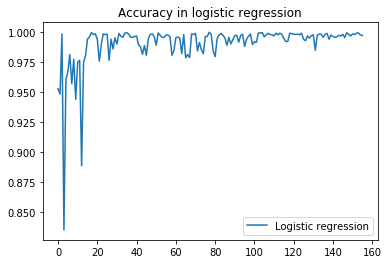

In [30]:
plt.plot(result_lg.accuracy,label='Logistic regression')
plt.title('Accuracy in logistic regression')
plt.legend()
plt.show()

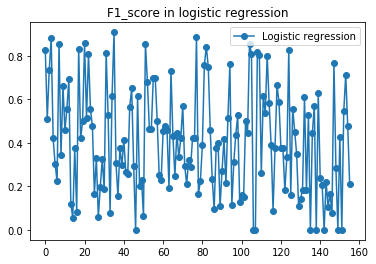

In [31]:
plt.plot(result_lg.f1_score,label='Logistic regression',marker='o')
plt.title('F1_score in logistic regression')
plt.legend()
plt.show()

# 4.2 Random Forest

In [34]:
accuracy_rf = []
f1_score_rf = []
roc_rf = []

# compute how many 1 in each model
sum_train=[]
sum_test=[]

X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

for num_models in range(0,156): 
    # create train and test
    y_train = []
    y_test = []
    for i  in range(len(df_train_1)):
        y_train.append(int(df_train_1['Vec_Tags'].iloc[i].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    for j  in range(len(df_test_1)):
        y_test.append(int(df_test_1['Vec_Tags'].iloc[j].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    
    sum_train.append(sum(y_train))
    sum_test.append(sum(y_test))
    
    # Random Forest
    rf = RandomForestClassifier(max_depth=5,class_weight='balanced').fit(X_train_rf, y_train)
    y_pred_rf_test = rf.predict(X_test_rf)
    y_pred_rf_train = rf.predict(X_train_rf)
    y_score_rf = rf.predict_proba(X_test_rf)[:,1]
    acc_rf = accuracy_score(y_test, y_pred_rf_test)
    f1_score_rf_result = metrics.f1_score(y_test, y_pred_rf_test)
    roc_rf_result = metrics.roc_auc_score(y_test, y_score_rf)
    accuracy_rf.append(acc_rf)
    f1_score_rf.append(f1_score_rf_result)
    roc_rf.append(roc_rf_result)
    
    # create new column: the predict result for the next model
    X_train_rf['predict_'+str(num_models)] = y_pred_rf_train
    X_test_rf['predict_'+str(num_models)] = y_pred_rf_test

In [35]:
data_tuples = list(zip(accuracy_rf,f1_score_rf,roc_rf,sum_train,sum_test))
result_rf = pd.DataFrame(data_tuples,columns=['accuracy','f1_score','roc','sum_train','sum_test'])
result_rf['sum_train'] = result_rf['sum_train']/len(y_train)
result_rf['sum_test'] = result_rf['sum_test']/len(y_test)
result_rf

,accuracy,f1_score,roc,sum_train,sum_test
0,0.945564,0.813289,0.963581,0.142157,0.139675
1,0.900232,0.462982,0.907639,0.059869,0.061798
2,0.999031,0.782609,0.946123,0.002989,0.002712
3,0.798915,0.855311,0.846129,0.673337,0.674932
4,0.851027,0.288622,0.912284,0.038778,0.038357
...,...,...,...,...,...
151,0.999031,0.000000,0.919604,0.001661,0.000969
152,0.987602,0.085714,0.866356,0.001993,0.000969
153,0.986827,0.128205,0.953610,0.001744,0.001356
154,0.996707,0.320000,0.990156,0.001993,0.003100


In [36]:
# MacroF1 score
result_rf.f1_score.mean()

0.3576545081982903

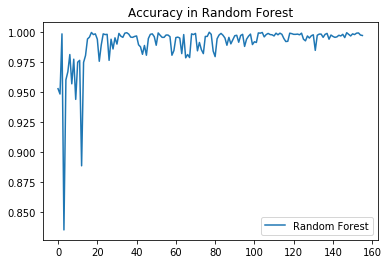

In [37]:
plt.plot(result_lg.accuracy,label='Random Forest')
plt.title('Accuracy in Random Forest')
plt.legend()
plt.show()

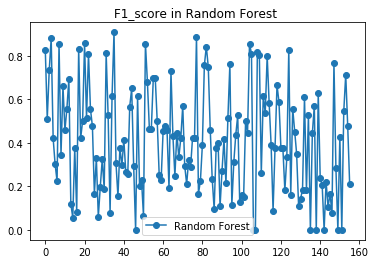

In [38]:
plt.plot(result_lg.f1_score,label='Random Forest',marker='o')
plt.title('F1_score in Random Forest ')
plt.legend()
plt.show()

# 4.3 LinearSVM

In [ ]:
accuracy_svm = []
f1_score_svm = []
roc_svm = []

# compute how many 1 in each model
sum_train=[]
sum_test=[]


for num_models in range(0,156): 
    # create train and test
    y_train = []
    y_test = []
    for i  in range(len(df_train_new)):
        y_train.append(int(df_train_new['Vec_Tags'].iloc[i].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    for j  in range(len(df_test_new)):
        y_test.append(int(df_test_new['Vec_Tags'].iloc[j].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    
    sum_train.append(sum(y_train))
    sum_test.append(sum(y_test))
    
    # Linear SVM
    svm = LinearSVC().fit(X_train, y_train)
    y_pred_svm_test = svm.predict(X_test)
    y_pred_svm_train = svm.predict(X_train)
 #   y_score_svm = svm.predict_proba(X_test)[:,1]
    acc_svm = accuracy_score(y_test, y_pred_svm_test)
    f1_score_svm_result = metrics.f1_score(y_test, y_pred_svm_test)
#    roc_svm_result = metrics.roc_auc_score(y_test, y_score_svm)
    accuracy_svm.append(acc_svm)
    f1_score_svm.append(f1_score_svm_result)
 #   roc_svm.append(roc_svm_result)
    
    # create new column: the predict result for the next model
    X_train['predict_'+str(num_models)] = y_pred_svm_train
    X_test['predict_'+str(num_models)] = y_pred_svm_test

In [ ]:
data_tuples = list(zip(accuracy_svm,f1_score_svm,sum_train,sum_test))
result_svm = pd.DataFrame(data_tuples,columns=['accuracy','f1_score','sum_train','sum_test'])
result_svm['sum_train'] = result_svm['sum_train']/len(y_train)
result_svm['sum_test'] = result_svm['sum_test']/len(y_test)
result_svm

In [ ]:
# MacroF1 Score
result_svm.f1_score.mean()

In [ ]:
plt.plot(result_lg.accuracy,label='Linear SVM')
plt.title('Accuracy in Linear SVM')
plt.legend()
plt.show()

In [ ]:
plt.plot(result_lg.f1_score,label='Linear SVM',marker='o')
plt.title('F1_score in Linear SVM')
plt.legend()
plt.show()

# Calculate accuracy score for each article

In [67]:
# Calculate accuracy score for each article
def accuracy_by_article(df):
    result_predict = df.iloc[:,-156:]
    wrong_result_predict=[]
    for i in range(len(result_predict)):
        difference_article=[]
        for m in range(0,156):
            # check whether predicted value is equal to the true value
            difference_article.append(abs(result_predict.iloc[i][m] - int(df_test_1['Vec_Tags'].iloc[i].split(']')[0].split('[')[1].split(',')[m].rstrip(' ').lstrip(' '))))
        wrong_result_predict.append(sum(difference_article))   
    
    # Create the dataframe of number of tags that are predicted wrongly and the tag_count for each article
    data_tuples = list(zip(wrong_result_predict,df_test_1['Tag_Count']))
    accuracy_article= pd.DataFrame(data_tuples,columns=['Num_tag_predict_wrong','Tag_Count'])
    
    # Add the accuracy column to calculate the accuracy score for each article
    accuracy_article['accuracy_article'] = ''
    for i in range(len(accuracy_article)):
        if accuracy_article['Num_tag_predict_wrong'].iloc[i]==0:
            accuracy_article['accuracy_article'].iloc[i]=1
        else:
            accuracy_article['accuracy_article'].iloc[i] = 1.0-(accuracy_article['Num_tag_predict_wrong'].iloc[i]/len(tag_index_new))

    return accuracy_article

In [68]:
# Use the function to calculate the accuracy by article
# If you hope to see the result of logistic regression, you can use 'X_test_lg'
# If you hope to see the result of random forest, you can use 'X_test_rf'
# etc...
accuracy_for_each_article=accuracy_by_article(X_test_lg)

# Save it into 'Artivle accuracy_lg.csv'
accuracy_for_each_article.to_csv('Article accuracy_lg.csv')

In [69]:
accuracy_for_each_article

,Num_tag_predict_wrong,Tag_Count,accuracy_article
0,0,3,1
1,0,2,1
2,0,3,1
3,6,8,0.97
4,4,3,0.98
...,...,...,...
5157,0,2,1
5158,0,2,1
5159,1,2,0.995
5160,1,2,0.995


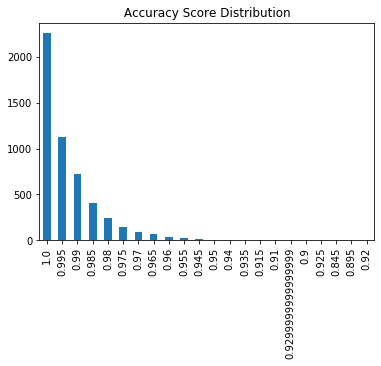

In [70]:
# Plot the accuracy score distribution
accuracy_for_each_article.accuracy_article.value_counts().plot(kind='bar')
plt.title(' Accuracy Score Distribution ')
plt.show()